# Decision Tree Based on an Individuals Top 3 Events

In [105]:
#import statements
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split

### Set Up (Data reading and preprocessing)

In [106]:
#read data
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')
df.head()

,Event,Conf_Rank,Time,Name,School,Standard,Date,Gender,Division,Season,SeasonYear,Time_Adj,Time_Sec,Div_Rank,NCAA_Rank,ID,Power_Tot,Power,Record,Points
0,50 Freestyle SCY Male,-1,21.22,Ben Beldner,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.220000,21.22,-1,-1,394588,22.71,20.52,17.63,573.483330
1,50 Freestyle SCY Male,-1,20.87,Justin Meyn,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:20.870000,20.87,-1,-1,471360,10.06,20.80,17.63,602.822689
2,50 Freestyle SCY Male,-1,21.31,Joshua Franco,New Jersey Institute of Technology,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.310000,21.31,-1,-1,395308,12.40,22.05,17.63,566.247878
3,50 Freestyle SCY Male,-1,21.05,Gabe Laracuente,UMBC,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.050000,21.05,-1,-1,404642,13.77,23.93,17.63,587.490213
4,50 Freestyle SCY Male,-1,21.70,Ryan Board,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.700000,21.70,-1,-1,422211,18.21,28.82,17.63,536.262879


In [107]:
#format to make future calculations
df.loc[:,'isHS'] = df.loc[:,'Division'] == 'HS'
df.loc[:, 'isHS'] = 'Col'  # Default to 'Col'

df.loc[df['Division'] == 'HS', 'isHS'] = 'HS'

/tmp/ipykernel_603156/2880209641.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Col' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, 'isHS'] = 'Col'  # Default to 'Col'


In [108]:
#group the data and create pivot table based on points
grouped = pd.pivot_table(df,index=['ID','Event'],columns='isHS',values='Points',aggfunc='max').reset_index()
grouped.dtypes

#find top 3 event by unique id
grouped = grouped.dropna()

# Step 1: Filter the rows where 'isHS' == 0 (we use the '0' column here)
filtered = grouped[grouped['Col'].notna()]  # Ensure we're only looking at rows where Points (for isHS == 0) are not NaN

# Step 2: Sort the filtered DataFrame by the '0' column (Points for isHS == 0) in descending order
sorted_filtered = filtered.sort_values(by='Col', ascending=False)

# Step 3: For each unique ID, get the top 3 rows based on the '0' column (Points for isHS == 0)
top_3_per_id = sorted_filtered.groupby('ID').head(3)

# Step 4: Count the number of entries for each 'ID' and filter to keep only those with at least 3 entries
valid_ids = top_3_per_id.groupby('ID').size()
valid_ids = valid_ids[valid_ids >= 3].index  # IDs with at least 3 entries

# Step 5: Filter the DataFrame to keep only the valid IDs
top_3_valid_ids = top_3_per_id[top_3_per_id['ID'].isin(valid_ids)]

# Display the result
print(top_3_valid_ids.sort_values(by="ID"))

isHS         ID                           Event         Col          HS
15         3480         200 Backstroke SCY Male  462.749670  656.537006
11         3480          100 Freestyle SCY Male  443.522321  585.648075
8          3480         100 Backstroke SCY Male  496.925131  604.120059
34         7361           50 Freestyle SCY Male  462.330341  551.368000
30         7361          200 Freestyle SCY Male  512.727092  707.657252
...         ...                             ...         ...         ...
163234  2968147       100 Breaststroke SCY Male  516.504001  312.104197
163243  2968147  200 Individual Medley SCY Male  477.594308  334.388650
163261  3008853         50 Freestyle SCY Female  542.245286  265.838311
163262  3008853        500 Freestyle SCY Female  428.375514  198.685297
163256  3008853        200 Freestyle SCY Female  467.686020  209.716608

[28260 rows x 4 columns]


/tmp/ipykernel_603156/432211106.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped = pd.pivot_table(df,index=['ID','Event'],columns='isHS',values='Points',aggfunc='max').reset_index()


## Decision Tree!

In [114]:
#calculate the point difference
top_3_valid_ids['Difference'] =top_3_valid_ids['Col'] - top_3_valid_ids['HS']

/tmp/ipykernel_603156/2733795426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_valid_ids['Difference'] =top_3_valid_ids['Col'] - top_3_valid_ids['HS']


In [115]:
top_3_valid_ids.head()

isHS,ID,Event,Col,HS,Difference
99876,576911,200 Freestyle SCY Male,1000.000000,846.306337,153.693663
42382,423426,100 Freestyle SCY Female,1000.000000,868.894762,131.105238
42389,423426,50 Freestyle SCY Female,1000.000000,861.237804,138.762196
32219,404919,200 Backstroke SCY Male,1000.000000,847.698808,152.301192
1665,227249,200 Butterfly SCY Male,982.638222,831.398479,151.239744


In [119]:
#actually, we should be looking at the ids as a whole -- group by ids to find total difference and then bin
# df_agg = top_3_valid_ids.groupby("ID", as_index=False).agg({"Difference": "sum"})
df_agg = top_3_valid_ids
df_agg['hasImproved'] = pd.cut(df_agg.Difference, bins = [-float('inf'), df_agg['Difference'].mean(), float('inf')], labels = ['Not Improved', 'Improved'])

/tmp/ipykernel_603156/3462346765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['hasImproved'] = pd.cut(df_agg.Difference, bins = [-float('inf'), df_agg['Difference'].mean(), float('inf')], labels = ['Not Improved', 'Improved'])


In [120]:
df_agg.head()

isHS,ID,Event,Col,HS,Difference,hasImproved
99876,576911,200 Freestyle SCY Male,1000.000000,846.306337,153.693663,Improved
42382,423426,100 Freestyle SCY Female,1000.000000,868.894762,131.105238,Improved
42389,423426,50 Freestyle SCY Female,1000.000000,861.237804,138.762196,Improved
32219,404919,200 Backstroke SCY Male,1000.000000,847.698808,152.301192,Improved
1665,227249,200 Butterfly SCY Male,982.638222,831.398479,151.239744,Improved


In [121]:
#merge with the original dataframe so that we can actually run the decision tree on it
merged = pd.merge(df[['ID', 'Event', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  df_agg, 
                  on=['ID'], 
                  how='left')

merged.head()

,ID,Event_x,School,Standard,Gender,Division,Season,Event_y,Col,HS,Difference,hasImproved
0,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Freestyle SCY Male,641.655324,611.822034,29.833290,Not Improved
1,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,50 Freestyle SCY Male,609.808493,573.483330,36.325164,Not Improved
2,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Butterfly SCY Male,608.775509,577.016850,31.758659,Not Improved
3,471360,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Breaststroke SCY Male,700.365094,641.120501,59.244593,Improved
4,471360,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Freestyle SCY Male,695.222056,678.814528,16.407528,Not Improved


In [122]:
merged['hasImproved'].value_counts()

hasImproved
Not Improved    505508
Improved        409849
Name: count, dtype: int64

In [123]:
#lets check and see how many entirs per id
merged[merged['ID'] == 394588].head() 

#there are potentially a lot of entries per a single id. 

,ID,Event_x,School,Standard,Gender,Division,Season,Event_y,Col,HS,Difference,hasImproved
0,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Freestyle SCY Male,641.655324,611.822034,29.833290,Not Improved
1,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,50 Freestyle SCY Male,609.808493,573.483330,36.325164,Not Improved
2,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Butterfly SCY Male,608.775509,577.016850,31.758659,Not Improved
29483,394588,100 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,100 Freestyle SCY Male,641.655324,611.822034,29.833290,Not Improved
29484,394588,100 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,50 Freestyle SCY Male,609.808493,573.483330,36.325164,Not Improved


In [124]:
merged["hasImproved"] = merged["hasImproved"].map({"Improved": 1, "Not Improved": 0})  # Binary target

merged = merged.dropna()
# Split data into features and target
X = merged[['Gender', 'Division', 'Season']]
y = merged["hasImproved"]

X.head()


,Gender,Division,Season
0,M,HS,00_01
1,M,HS,00_01
2,M,HS,00_01
3,M,HS,00_01
4,M,HS,00_01


In [125]:
X_ohe = pd.get_dummies(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=42)


In [126]:
# Train a Decision Tree
model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Prevent overfitting
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


In [127]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.64      0.66      0.65    100987
           1       0.56      0.54      0.55     82085

    accuracy                           0.60    183072
   macro avg       0.60      0.60      0.60    183072
weighted avg       0.60      0.60      0.60    183072



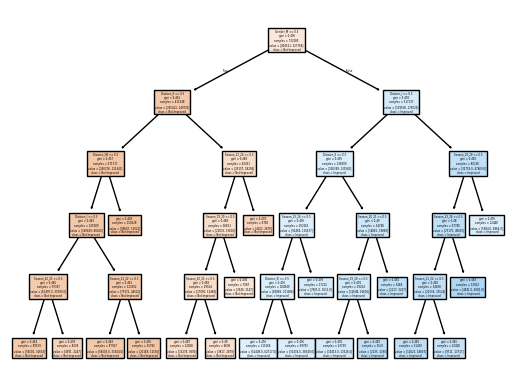

In [134]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree #gpt gave me this

# plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X_ohe.columns, class_names=["Not Improved", "Improved"], filled=True)
plt.show()

In [132]:
#print out the export string
dtree_string = export_text(model,feature_names=list(X_ohe.columns),decimals=1,spacing=5)
print(dtree_string)

|----- Gender_M <= 0.5
|     |----- Division_II <= 0.5
|     |     |----- Division_HS <= 0.5
|     |     |     |----- Division_I <= 0.5
|     |     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |     |----- class: 0
|     |     |     |     |----- Season_20_21 >  0.5
|     |     |     |     |     |----- class: 0
|     |     |     |----- Division_I >  0.5
|     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |----- class: 0
|     |     |     |     |----- Season_21_22 >  0.5
|     |     |     |     |     |----- class: 0
|     |     |----- Division_HS >  0.5
|     |     |     |----- class: 0
|     |----- Division_II >  0.5
|     |     |----- Season_23_24 <= 0.5
|     |     |     |----- Season_19_20 <= 0.5
|     |     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |     |----- class: 0
|     |     |     |     |----- Season_20_21 >  0.5
|     |     |     |     |     |----- class: 0
|     |     |     |----- Season_19_20 >  0.5
|     

In [133]:
importances = model.feature_importances_
df_importances = pd.DataFrame()
df_importances['features'] = X_ohe.columns
df_importances['importances'] = importances
df_importances

,features,importances
0,Gender_F,0.000000
1,Gender_M,0.944938
2,Division_HS,0.007321
3,Division_I,0.013413
4,Division_II,0.025568
5,Division_III,0.000140
6,Season_00_01,0.000000
7,Season_19_20,0.004168
8,Season_20_21,0.001313
9,Season_21_22,0.000684


### Results
Further trees need to be made. The results show that Females are more likely to not improve from high school to college. Ie that they peak in high school, while men peak in college. 

Furthermore, looking at only at an individuals top 3 events yields similar results to looking at all events. 